In [1]:
latex_dir = 'LaTex/img/'
EXPORT_FOR_LATEX = True

def plot_images(plot, figname=None):
    if EXPORT_FOR_LATEX:
        plt.savefig(latex_dir+figname+'.pdf', bbox_inches='tight')
    else:
        plot.show()

In [2]:
%matplotlib inline
import sys, os
%env THEANO_FLAGS=mode=FAST_RUN,device=gpu0,floatX=float32
%env KERAS_BACKEND=theano
from collections import OrderedDict
from keras.layers import InputLayer, BatchNormalization, Dense, Conv2D, Deconv2D, Activation, Flatten, Reshape
import numpy as np
import pymc3 as pm
from theano import shared, config, function, clone, pp
import theano.tensor as tt
import keras
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from keras import backend as K
K.set_image_dim_ordering('th')

import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns
from theano import shared
from scipy import stats as st
import keras


env: THEANO_FLAGS=mode=FAST_RUN,device=gpu0,floatX=float32


Using TensorFlow backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

ERROR (theano.sandbox.cuda): nvcc compiler not found on $PATH. Check your nvcc installation and try again.


env: KERAS_BACKEND=theano


In [3]:
class Decoder:
    """Decode hidden variables to images.

    Parameters
    ----------
    zs : Theano tensor
        Hidden variables.
    """
    def __init__(self, zs, net):
        model = net(zs)
        self.model = model
        self.zs = zs
        self.out = model.get_output_at(-1)
        self.params, self.updates = get_params(model)
        self.dec_func = None

    def _get_dec_func(self):
        if self.dec_func is None:
            zs = tt.matrix()
            xs = clone(self.out, {self.zs: zs})
            self.dec_func = function([zs], xs)

        return self.dec_func

    def decode(self, zs):
        """Decode hidden variables to images.

        An image consists of the mean parameters of the observation noise.

        Parameters
        ----------
        zs : numpy.ndarray, shape=(n_samples, dim_hidden)
            Hidden variables.
        """
        # Used in test phase
        #keras.backend.theano_backend._LEARNING_PHASE.set_value(np.uint8(0))

        return self._get_dec_func()(zs)

In [ ]:
class Encoder:
    """Encode observed images to variational parameters (mean/std of Gaussian).

    Parameters
    ----------
    xs : theano.tensor.sharedvar.TensorSharedVariable
        Placeholder of input images.
    dim_hidden : int
        The number of hidden variables.
    net : Function
        Returns
    """
    def __init__(self, xs, dim_hidden, net):
        model = net(xs, dim_hidden)

        self.model = model
        self.xs = xs
        self.out = model.get_output_at(-1)
        self.means = self.out[:, :dim_hidden]
        self.rhos = self.out[:, dim_hidden:]
        self.params, self.updates = get_params(model)
        self.enc_func = None
        self.dim_hidden = dim_hidden

    def _get_enc_func(self):
        if self.enc_func is None:
            xs = tt.tensor4()
            means = clone(self.means, {self.xs: xs})
            rhos = clone(self.rhos, {self.xs: xs})
            self.enc_func = function([xs], [means, rhos])

        return self.enc_func

    def encode(self, xs):
        # Used in test phase
        keras.backend.theano_backend._LEARNING_PHASE.set_value(np.uint8(0))

        enc_func = self._get_enc_func()
        means, _ = enc_func(xs)

        return means

    def draw_samples(self, xs, n_samples=1):
        """Draw samples of hidden variables based on variational parameters encoded.

        Parameters
        ----------
        xs : numpy.ndarray, shape=(n_images, 1, height, width)
            Images.
        """
        # Used in test phase
        keras.backend.theano_backend._LEARNING_PHASE.set_value(np.uint8(0))

        enc_func = self._get_enc_func()
        means, rhos = enc_func(xs)
        means = np.repeat(means, n_samples, axis=0)
        rhos = np.repeat(rhos, n_samples, axis=0)
        ns = np.random.randn(len(xs) * n_samples, self.dim_hidden)
        zs = means + pm.distributions.dist_math.rho2sd(rhos) * ns

        return zs

In [ ]:
import pickle
model = pickle.load( open('weights/fullmodel.pkl','rb'))
dec = pickle.load( open('weights/dec.pkl','rb'))
enc = pickle.load( open('weights/enc.pkl','rb'))

In [ ]:
nn = 9
zs = np.array([(z1, z2)
               for z1 in np.linspace(-1, 1, nn)
               for z2 in np.linspace(-1, 1, nn)]).astype('float32')
xs = dec.decode(zs)[:, 0, :, :]
print(xs.shape)

xs = np.bmat([[xs[i + j * nn] for i in range(nn)] for j in range(nn)])
matplotlib.rc('axes', **{'grid': False})
plt.figure(figsize=(10, 10))
plt.imshow(xs, interpolation='none', cmap='bone')
plt.show()

In [13]:
from keras.datasets import mnist

In [15]:
f, axes = plt.subplots(1,10,figsize=(10,1.3), sharey=True)
f.suptitle('a few real samples from MNIST', y=1.05)
MNIST = mnist.load_data()
for i,ax in enumerate(axes):
    ax.imshow(MNIST[0][0][i], cmap='bone_r', 
              interpolation='gaussian', aspect=1.0)
    ax.tick_params(axis='both', colors='darkgrey')
plt.tight_layout()
plot_images(plt,'5_4')

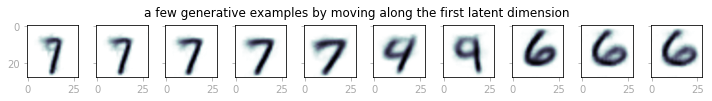

In [16]:
f, axes = plt.subplots(1,10,figsize=(10,1.3), sharey=True)
f.suptitle('a few generative examples by moving along the first latent dimension', y=1.05)
a = np.linspace(-3,1,len(axes))
b = 0
for i,ax in enumerate(axes):
    ax.imshow(dec.decode(np.array([[a[i],b]]).astype('float32'))[:, 0, :, :].reshape(28,28), 
              cmap='bone_r', interpolation='catrom', aspect=1.0)
    ax.tick_params(axis='both', colors='darkgrey')
plt.tight_layout()
plot_images(plt,'5_5')

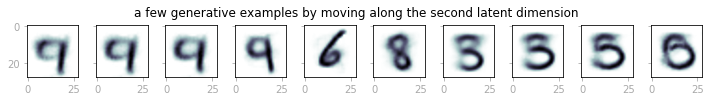

In [17]:
f, axes = plt.subplots(1,10,figsize=(10,1.3), sharey=True)
f.suptitle('a few generative examples by moving along the second latent dimension', y=1.05)
a = np.linspace(-1,2,len(axes))
b = -.3
for i,ax in enumerate(axes):
    ax.imshow(dec.decode(np.array([[b,a[i]]]).astype('float32'))[:, 0, :, :].reshape(28,28), 
              cmap='bone_r', interpolation='catrom', aspect=1.0)
    ax.tick_params(axis='both', colors='darkgrey')
plt.tight_layout()
plot_images(plt,'5_6')